# Comparing `getps` between `Dysh` and `GBTIDL`.

In GBTIDL, from the `src/dysh/fits/tests/data` directory:
```
filein,"TGBT21A_501_11.raw.vegas.fits"
getps,152,ifnum=0,plnum=0,intnum=0
fileout,"TGBT21A_501_11_getps_scan_152_intnum_0_ifnum_0_plnum_0.fits"
keep
```
Look at the `TCAL` value and the computed `TSYS`:
```
print,!g.s[0].mean_tcal
   1.4551637
print,!g.s[0].tsys
   17.2400
```
`GBTIDL` seems to use a lower precision?
```
PRINT, SIZE(!g.s[0].tsys)
           0           4           1
```
Code 4 is for float, not double :)  [reference](https://www.l3harrisgeospatial.com/docs/size.html)

I tried figuring out why `GBTIDL` uses float instead of double, but could not. `GBTIDL` seems to load the data from the `SDFITS` without applying any type conversion, so I do not understand what happens.

So, let's check what happens if we re-scale the `dysh` results using a lower precison `TSYS` or the `TSYS` saved by `GBTIDL`.

Using the `TSYS` saved by GBTIDL makes the difference smaller. However, I still cannot figure out how to reproduce the `GBTIDL` value for `TSYS` starting from the raw data...

Also note that there is no .flag file here, so `GBTIDL` is not using any external flags.

**Solved:** The issues is that `IDL` uses inclusive ranges and `Python` does not. Increasing the upper edge to consider one extra channel makes the difference go away!

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

from astropy.io import fits

from dysh.fits.gbtfitsload import GBTFITSLoad

In [3]:
file1 = "../../src/dysh/fits/tests/data/TGBT21A_501_11_getps_scan_152_intnum_0_ifnum_0_plnum_0.fits"
file2 = "../../src/dysh/fits/tests/data/TGBT21A_501_11.raw.vegas.fits"

In [4]:
hdu1 = fits.open(file1)
gbtidl = hdu1[1].data

In [5]:
sdf = GBTFITSLoad(file2)
psscan = sdf.getps(152)
psscan.calibrate()
dysh_getps = psscan[0].calibrated(0).flux.to("K").value
dysh_getps_rescaled_low = dysh_getps/psscan[0]._tsys*17.2400   # Lower precision
dysh_getps_rescaled_sav = dysh_getps/psscan[0]._tsys*gbtidl["TSYS"] # Using the stored value

FILE  ../../src/dysh/fits/tests/data/TGBT21A_501_11.raw.vegas.fits
FILE  ../../src/dysh/fits/tests/data/TGBT21A_501_11.raw.vegas.fits


In [6]:
print("GBTIDL vs Dysh native")
print("STD:", np.nanstd(gbtidl["DATA"][0] - dysh_getps))
print("MEDIAN:", np.nanmedian(gbtidl["DATA"][0] - dysh_getps))
print("\n")
print("GBTIDL vs Dysh rescaled to low precision")
print("STD:", np.nanstd(gbtidl["DATA"][0] - dysh_getps_rescaled_low))
print("MEDIAN:", np.nanmedian(gbtidl["DATA"][0] - dysh_getps_rescaled_low))
print("\n")
print("GBTIDL vs Dysh rescaled to saved TSYS")
print("STD:", np.nanstd(gbtidl["DATA"][0] - dysh_getps_rescaled_sav))
print("MEDIAN:", np.nanmedian(gbtidl["DATA"][0] - dysh_getps_rescaled_sav))

GBTIDL vs Dysh native
STD: 3.589269861319414e-08
MEDIAN: 0.0


GBTIDL vs Dysh rescaled to low precision
STD: 1.355511573568983e-07
MEDIAN: 3.529158446036185e-08


GBTIDL vs Dysh rescaled to saved TSYS
STD: 3.743899280915053e-08
MEDIAN: -3.010581672846513e-09


It is better to use the value stored by `GBTIDL` rather than what gets printed.

In [7]:
psscan[0]._tsys

array([17.24000331])

In [8]:
gbtidl["TSYS"], gbtidl["TCAL"]

(array([17.24000359]), array([1.45516372]))

In [9]:
print(psscan[0]._tsys/gbtidl["TSYS"] - 1.)

[-1.62127882e-08]


In [10]:
# This is the difference we observe between `getps` in `GBTIDL` and `Dysh`.
print(psscan[0]._tsys/gbtidl["TSYS"] - 1.)

[-1.62127882e-08]


In [11]:
# Let's try to reproduce the `TSYS` calculation.
hdu2 = fits.open(file2)
table2 = hdu2[1].data

In [12]:
# Where are our sig-ref?
table2["CAL"], table2["PROCSEQN"], table2["OBSMODE"], table2["TCAL"]
# Why is `TCAL` different for the OFF position??

(chararray(['T', 'F', 'T', 'F'], dtype='<U1'),
 array([1, 1, 2, 2], dtype=int16),
 chararray(['OnOff:PSWITCHON:TPWCAL', 'OnOff:PSWITCHON:TPWCAL',
            'OnOff:PSWITCHOFF:TPWCAL', 'OnOff:PSWITCHOFF:TPWCAL'],
           dtype='<U32'),
 array([1.45516372, 1.45516372, 1.45516419, 1.45516419]))

In [13]:
data2 = table2["DATA"].astype(np.float64)

In [14]:
# Unpack arrays.
nchan = data2.shape[1]
chi = int(0.1*nchan)
chf = int(0.9*nchan) + 1 + 1 # IDL uses inclusive channel ranges!
print("Channel range: ", chi, chf)
sig_on = data2[0,chi:chf]
sig_off = data2[1,chi:chf]
sig_tcal = table2["TCAL"][0]
ref_on = data2[2,chi:chf]
ref_off = data2[3,chi:chf]
ref_tcal = table2["TCAL"][2]

Channel range:  3276 29493


In [15]:
tsys_sig = sig_tcal * np.nanmean(sig_off) / np.nanmean((sig_on - sig_off)) + sig_tcal/2.
tsys_ref = ref_tcal * np.nanmean(ref_off) / np.nanmean((ref_on - ref_off)) + ref_tcal/2.

print(tsys_sig, tsys_ref)
# Now they match!

17.45805259378602 17.240003306306875


In [16]:
gbtidl["TSYS"], gbtidl["TCAL"], ref_tcal, sig_tcal

(array([17.24000359]),
 array([1.45516372]),
 1.4551641941070557,
 1.4551637172698975)

In [17]:
print(f"{np.nanmean(ref_off):e}")

5.081326e+08


In [18]:
np.nanmean(ref_off)

508132643.4396003

In [19]:
np.nanmean(data2[3,3276:29492+1])

508132643.4396003

# Copy of our pytests
------------------

In [20]:
test_data_dir = "/home/mpound/src/dysh/src/dysh/fits/tests/"

In [21]:
def test_getps_single_int():

    gbtidl_file = test_data_dir+"data/TGBT21A_501_11_getps_scan_152_intnum_0_ifnum_0_plnum_0.fits"
    hdu = fits.open(gbtidl_file)
    gbtidl_getps = hdu[1].data["DATA"][0]
    sdf_file = test_data_dir+"data/TGBT21A_501_11.raw.vegas.fits"
    sdf = GBTFITSLoad(sdf_file)
    psscan = sdf.getps(152)
    assert len(psscan) == 1
    psscan.calibrate()
    dysh_getps = psscan[0].calibrated(0).flux.to("K").value
    diff = gbtidl_getps - dysh_getps
    assert np.nanmedian(diff) == 0.0
    assert np.all(abs(diff[~np.isnan(diff)]) < 5e-7)
    assert np.isnan(diff[3072])


In [22]:
def test_gettp_single_int(debug=False):
    gbtidl_file = test_data_dir+"data/TGBT21A_501_11_gettp_scan_152_intnum_0_ifnum_0_plnum_0_cal_state_1.fits"
    hdu = fits.open(gbtidl_file)
    gbtidl_gettp = hdu[1].data["DATA"][0]
    sdf_file = test_data_dir+"data/TGBT21A_501_11.raw.vegas.fits"
    sdf = GBTFITSLoad(sdf_file)
    tps_on = sdf.gettp(152, sig=True, cal=True, calibrate=False)

    assert len(tps_on) == 1
    diff = tps_on[0].total_power(0).flux.value - gbtidl_gettp
    assert np.nanmean(diff) == 0.0
    tps_off = sdf.gettp(152, sig=True, cal=False, calibrate=False)
    assert len(tps_off) == 1
    gbtidl_file = test_data_dir+"data/TGBT21A_501_11_gettp_scan_152_intnum_0_ifnum_0_plnum_0_cal_state_0.fits"
    hdu = fits.open(gbtidl_file)
    gbtidl_gettp = hdu[1].data["DATA"][0]
    diff = tps_off[0].total_power(0).flux.value - gbtidl_gettp
    assert np.nanmean(diff) == 0.0

    # Now, both on and off.
    tps = sdf.gettp(152, sig=True, cal=True)
    assert len(tps) == 1
    tps_tavg = tps.timeaverage()
    assert len(tps_tavg) == 1
    gbtidl_file = test_data_dir+"data/TGBT21A_501_11_gettp_scan_152_ifnum_0_plnum_0.fits"
    hdu = fits.open(gbtidl_file)
    table = hdu[1].data
    spec = table["DATA"][0]
    diff = tps[0].total_power(0).flux.value - spec
    assert np.nanmean(diff) == 0.0
    if debug:
        return tps

    

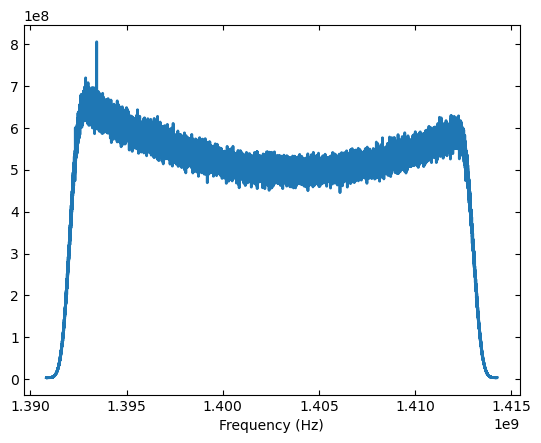

In [23]:
tps=test_gettp_single_int(True)
tps.timeaverage()[0].plot()

In [25]:
test_gettp_single_int(False)